In [1]:
import gc
import glob

import geopandas as gpd
import momepy as mm
import numpy as np
import pandas as pd
import shapely
from libpysal.graph import Graph, read_parquet
import datetime

regions_datadir = "/data/uscuni-ulce/"
data_dir = "/data/uscuni-ulce/processed_data/"
eubucco_files = glob.glob(regions_datadir + "eubucco_raw/*")
graph_dir = data_dir + "neigh_graphs/"
chars_dir = "/data/uscuni-ulce/processed_data/chars/"

In [2]:
## to build a new conda env
## conda install -c conda-forge momepy umap-learn fast_hdbscan jupyterlab pyarrow matplotlib lonboard folium mapclassify datashader bokeh holoviews dask
# pip install -e . for shapely, momepy, core, geoplanar, fast_hdbscan

In [6]:
region_name = 12199

In [7]:
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "regions_hull.parquet"
    )

In [8]:
region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.loc[region_name].convex_hull

In [9]:
## need to link eubucco building polygons to regions, this will change in the future
building_region_mapping = pd.read_parquet(
    regions_datadir + "regions/" + "id_to_region.parquet", engine="pyarrow"
)
typed_dict = pd.Series(
    np.arange(building_region_mapping["id"].values.shape[0]),
    index=building_region_mapping["id"].values,
)
region_ids = building_region_mapping.groupby("region")["id"].unique()
del building_region_mapping  # its 2/3 gb

## Streets

In [15]:
from core.generate_streets import process_region_streets

In [25]:
## overture is indexed based on 4326
overture_hull = region_hulls.loc[[region_name], ].to_crs(epsg=4326).convex_hull.iloc[0]

In [26]:
%%time
## processs streets
streets = process_region_streets(overture_hull, region_id)
## save streets
streets.to_parquet(data_dir + f"streets/streets_{region_id}.parquet")

CPU times: user 1.59 s, sys: 945 ms, total: 2.53 s
Wall time: 2min 21s


<Axes: >

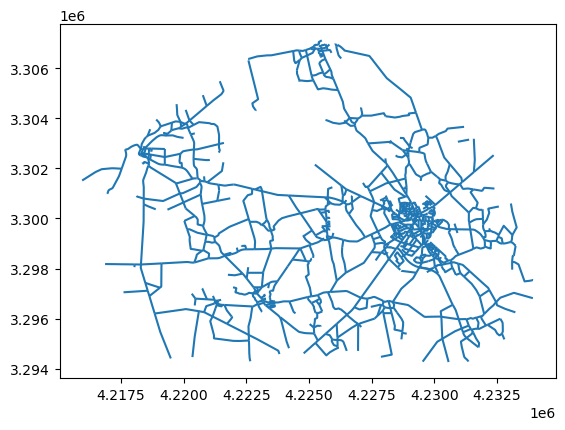

In [27]:
streets.plot()

## Buildings


In [10]:
from core.generate_buildings import read_region_buildings, process_region_buildings

In [11]:
%%time

buildings = read_region_buildings(
    typed_dict, region_ids, region_hull, region_id
)

buildings = process_region_buildings(buildings)

buildings.to_parquet(data_dir + f"buildings/buildings_{region_id}.parquet")

Percent polygons:  0.9984998928494893
Final polygons:  13764 , dropped:  0.11439969115943893
CPU times: user 41.8 s, sys: 911 ms, total: 42.7 s
Wall time: 42.2 s


In [30]:
import geoplanar

In [33]:
## fix invalid geometry
buildings["geometry"] = buildings.make_valid()

## explode multipolygons
buildings = buildings.explode(ignore_index=True)

## keep only polygons
buildings = buildings[buildings["geometry"].geom_type == "Polygon"].reset_index(
    drop=True
)


## merge buildings that overlap either 1) at least .10 percent or are smaller than 10m^2
buildings = geoplanar.merge_overlaps(
    buildings, merge_limit=10, overlap_limit=0.1
)

## drop remaining overlaps
buildings = geoplanar.trim_overlaps(buildings, largest=False)

## fix any multipolygons
buildings = buildings.explode(ignore_index=True)

print(
    "Percent polygons: ",
    (buildings.geom_type == "Polygon").sum() / buildings.shape[0],
)

# drop non-polygons - sometimes these are linestrings
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

# merge touching collapsing buildings
shrink = buildings.buffer(-0.4, resolution=2)
buildings = geoplanar.merge_touching(
    buildings, np.where(shrink.is_empty), largest=True
)
# drop non polygons
buildings = buildings.explode()
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

# fill gaps smaller than 10cm^2
gaps = geoplanar.gaps(buildings)
gaps = gaps[gaps.area < 0.1]
buildings = geoplanar.fill_gaps(buildings, gap_df=gaps, largest=None)

# drop non polygons
buildings = buildings.explode(ignore_index=True)
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

# gap filling without a precision grid has some issues
buildings = buildings[buildings.area > 1].reset_index(drop=True)

Percent polygons:  0.9987611135403003


In [34]:
buildings["geometry"] = geoplanar.snap(buildings, threshold=.5)

In [37]:
inp, res = buildings.sindex.query(buildings.geometry, predicate='overlaps') 

In [38]:
inp[np.where(inp !=res)]

array([   11,    13,    19, ..., 13768, 13769, 13769])

In [39]:
res[np.where(inp !=res)]

array([   13,    11,    20, ..., 13769, 13765, 13768])

In [34]:
# buildings.iloc[[1,2, 3, 5]].explore(max_zoom=50)

In [44]:
buildings.geometry.iloc[1].intersection(buildings.geometry.iloc[2]).length

8.36884630753549

In [36]:
buildings.iloc[[1,2, 3, 5]].is_valid

component labels
1    True
2    True
3    True
5    True
dtype: bool

In [14]:
geoplanar.is_overlapping(buildings)

True

In [109]:
gaps = geoplanar.gaps(buildings)
gaps = gaps[gaps.area < 0.1]

In [112]:
geoplanar.fill_gaps(buildings, gap_df=gaps, largest=None).area.sum() - gaps.area.sum() 

np.float64(1834324.838767691)

In [111]:
buildings.area.sum()

np.float64(1834505.4024593912)

In [113]:
gaps.area.sum()

np.float64(207.1124090955684)

In [92]:
shapely.difference(buildings.loc[75, 'geometry'],  buildings.loc[[75]].explode().loc[75, 'geometry']).area

0.0

In [48]:
buildings.shape

(13768, 2)

In [49]:
# buildings.explore()

In [50]:
buildings.shape

(13768, 2)

## Enclosures & Tessellation

In [12]:
from core.generate_elements import process_region_elements

In [13]:
%%time
enclosures, tesselations = process_region_elements(region_id)

enclosures.to_parquet(data_dir + f"enclosures/enclosure_{region_id}.parquet")
print("Processed enclosures")

## save files
tesselations.to_parquet(
    data_dir + f"tessellations/tessellation_{region_id}.parquet"
)
print("processed tesselations")

---- Processing region:  12199 2024-07-12 16:59:13.403660
Retrying tesselation with less buildings, potentially changing building data.
Dropping 2 buildings due to tesselation problems
Processed enclosures
processed tesselations
CPU times: user 9.21 s, sys: 1.8 s, total: 11 s
Wall time: 14.5 s


## Graphs

In [14]:
from core.generate_ngraphs import process_region_graphs

In [15]:
%%time
process_region_graphs(region_id)

Built tess graph knn=1
Built buildings graph knn=1
Built streets graph knn=1
Built enclosure graph knn=1
Built nodes graph knn=1
CPU times: user 2.32 s, sys: 68 ms, total: 2.39 s
Wall time: 2.38 s


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/libpysal/weights/weights.py:1685: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  w = W(neighbors, weights, ids, silence_warnings=silence_warnings)


## Characters

In [16]:
%%time
process_single_region_chars(region_id)

2024-07-12 16:59:30.328164 ----Processing ------ 12199
Processing streets
Processing enclosures
Processing buildings
TopologyException: side location conflict at 4222951.5835274039 3296628.9991301498. This can occur if the input geometry is invalid. 12199
Processing tessellation
CPU times: user 44.3 s, sys: 257 ms, total: 44.6 s
Wall time: 44.6 s


In [13]:
region_id = 69300

In [14]:
from core.generate_chars import process_enclosure_chars, process_building_chars, process_tessellation_chars, process_street_chars
# process_street_chars(69300)
# process_enclosure_chars(69300)
# process_building_chars(69300)
process_tessellation_chars(69300)

Processing tessellation


In [ ]:
# tessellation = gpd.read_parquet(
#         data_dir + f"tessellations/tessellation_{69300}.parquet"
#     )

# # import lonboard
# # # layer = lonboard.PolygonLayer.from_geopandas(tessellation, opacity=0.15)
# # # m = lonboard.Map([layer])
# # # m